In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

# Set variables
OUTCOME_VAR = 'inhosp_death_30day'
INPUT_VARS = ['age', 'bmi', 'andur', 'asa', 'emop',
              'preop_hb', 'preop_platelet', 'preop_wbc', 'preop_aptt', 'preop_ptinr', 'preop_glucose',
              'preop_bun', 'preop_ast', 'preop_alt', 'preop_creatinine', 'preop_sodium', 'preop_potassium',
              'Index', 'Elixhauser Indicator']

# Load operations
df = pd.read_csv('operations.csv')

# Find the first operation for each patient
df.sort_values('orin_time', inplace=True)
df = df.loc[df[['op_id','subject_id']].groupby('subject_id')['op_id'].idxmin()]

# Whether the time of in-hospital death ('inhosp_death_time') is less than the time when the patient was
# out of the operating room ('orout_time') plus 30 days (converted to minutes).
df[OUTCOME_VAR] = (df['inhosp_death_time'] < df['orout_time'] + 30 * 24 * 60)

# Filters to include only those rows where the value in the column 'asa' is less than 6. higher asa indicates more serious disease
df = df[(df['asa'] < 6)]

# Duration of anesthesia for each patient
df.loc[:, 'andur'] = df['anend_time'] - df['anstart_time']

# BMI only for rows where valid_mask is True (i.e., where height is greater than 10 cm).
valid_mask = df['height'] > 10
df['bmi'] = np.nan
df.loc[valid_mask, 'bmi'] = df.loc[valid_mask, 'weight'] / (df.loc[valid_mask, 'height'] / 100) ** 2

# Load labs
df_lab = pd.read_csv('labs.csv')

# Merge labs & operations
for item_name in ('hb', 'platelet', 'aptt', 'wbc', 'ptinr', 'glucose', 'bun', 'ast', 'alt', 'creatinine', 'sodium', 'potassium'):
    df = pd.merge_asof(df.sort_values('orin_time'),
                    df_lab.loc[df_lab['item_name'] == item_name].sort_values('chart_time'),
                    left_on='orin_time', right_on='chart_time', by='subject_id',
                    tolerance=6* 30 * 24 * 60, suffixes=('', '_'))
    df.drop(columns=['chart_time', 'item_name'], inplace=True)
    df.rename(columns={'value':f'preop_{item_name}'}, inplace=True)

# Load diagnosis data
df_diagnosis = pd.read_csv('diagnosis.csv')

# Merge diagnosis data with operations & medications
df = pd.merge(df, df_diagnosis[['subject_id', 'icd10_cm']], on='subject_id', how='left')

# Moving icd10_pcs to back of datafrmae
col = df.pop('icd10_pcs')
df['icd10_pcs'] = col

icd10_cm_scores_df = pd.read_csv("updated_icd10_cm_codes_with_comorbidities.csv")
icd10_pcs_scores_df = pd.read_csv("processed_icd10_pcs_codes_with_categories.csv")

# Set the indexes of the ICD10 scores dataframes for faster lookups
icd10_cm_scores_df.set_index('ICD10 Code', inplace=True)
icd10_pcs_scores_df.set_index('ICD10 Code', inplace=True)

# Create dictionaries for faster lookups
icd10_cm_dict = icd10_cm_scores_df['Elixhauser Indicator'].to_dict()
icd10_pcs_dict = icd10_pcs_scores_df['Index'].to_dict()

# Add the comorbidities scores to df
df['Elixhauser Indicator'] = df['icd10_cm'].map(icd10_cm_dict)
df['Index'] = df['icd10_pcs'].map(icd10_pcs_dict)

# cardiac patients pcs list
cardiac_patients_list = [
    "02RG0", "02100", "03BY0", "03VG3", "00160", "06BY0", "02QM0", "03120",
    "05DY0", "02RF0", "02B60", "031H0", "04100", "05HY0", "021K0", "03LG0",
    "03Q20", "03CY0", "03LG3", "02RJ0", "031J0", "001U0", "02C60", "03CH0",
    "02QF0", "05BY0", "04BK0", "04CY0", "03C50", "02B63", "037H0", "02110",
    "04RY0", "03VG0", "03R20", "03LY3", "03L20", "03B20", "047Y3", "03VH0",
    "03130", "05QY0", "0HRT0", "03720", "03L24", "03BJ0", "02YA0", "03CJ0",
    "03RY0", "0HRU0", "04CK0", "021W0", "02QG0", "04BY0", "03LK3", "02QJ0",
    "03LY0", "05VY0", "03920", "03C20", "02JA0", "06DM0", "06LY0", "04C50",
    "02BF0", "06BN0", "02Q00", "02B64", "02RA0", "03L23", "041L0", "04BL0",
    "06BM0", "06C80", "02QA0", "04CL0", "047Y0", "05LY0", "03VY0", "03140",
    "02Q60", "03QY0", "021P0", "02114", "06DN0", "03LK0", "02UF0", "03BY3"
]


# just cardiac patients
df = df[df['icd10_pcs'].isin(cardiac_patients_list)]

df = df.drop_duplicates(subset='subject_id')

len(df)

4856

37/3399 (1.09%) train, 16/1457 (1.10%) test, 19 features
ASA auroc: 0.524, auprc: 0.010
LR auroc: 0.939, auprc: 0.350
 
 


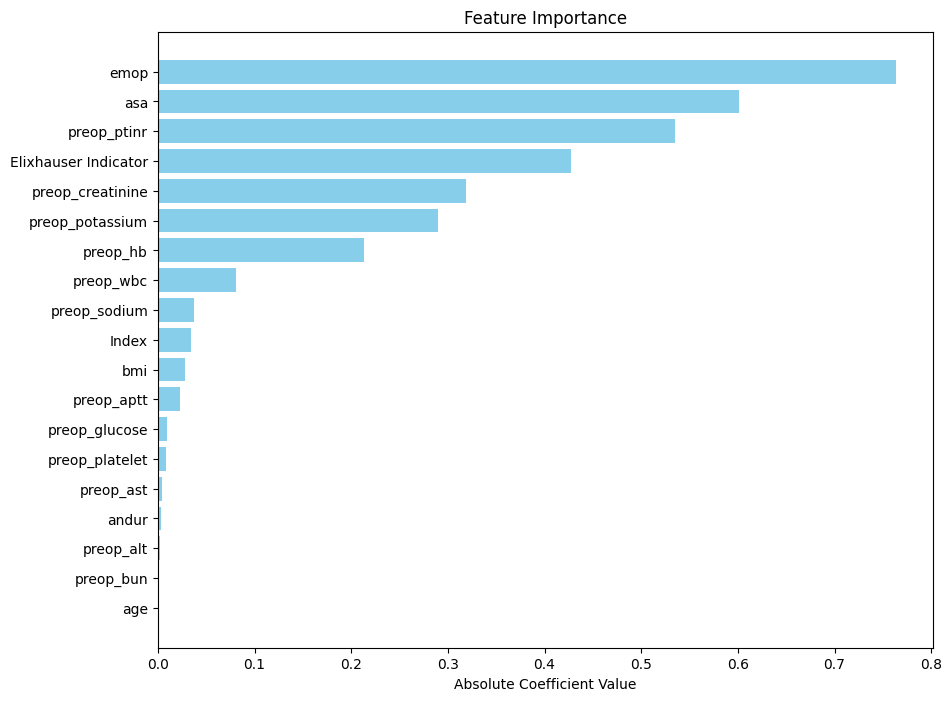

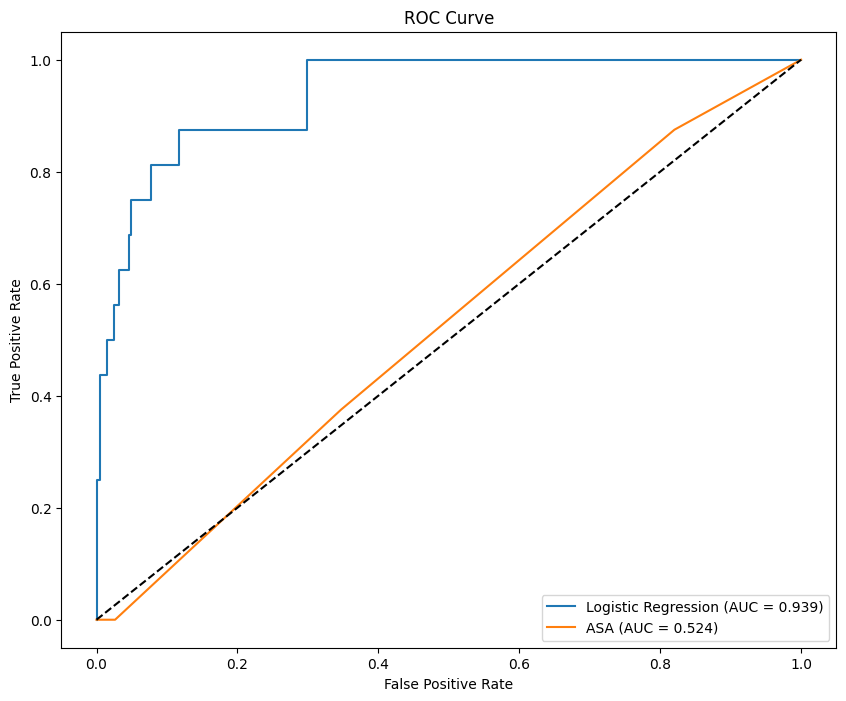

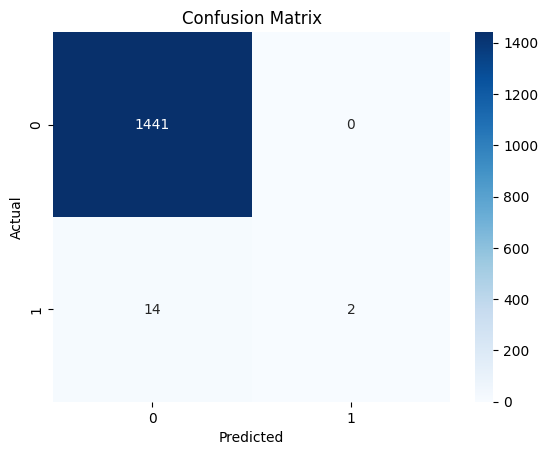

Accuracy: 0.990
Precision: 1.000
Recall: 0.125
F1 Score: 0.222


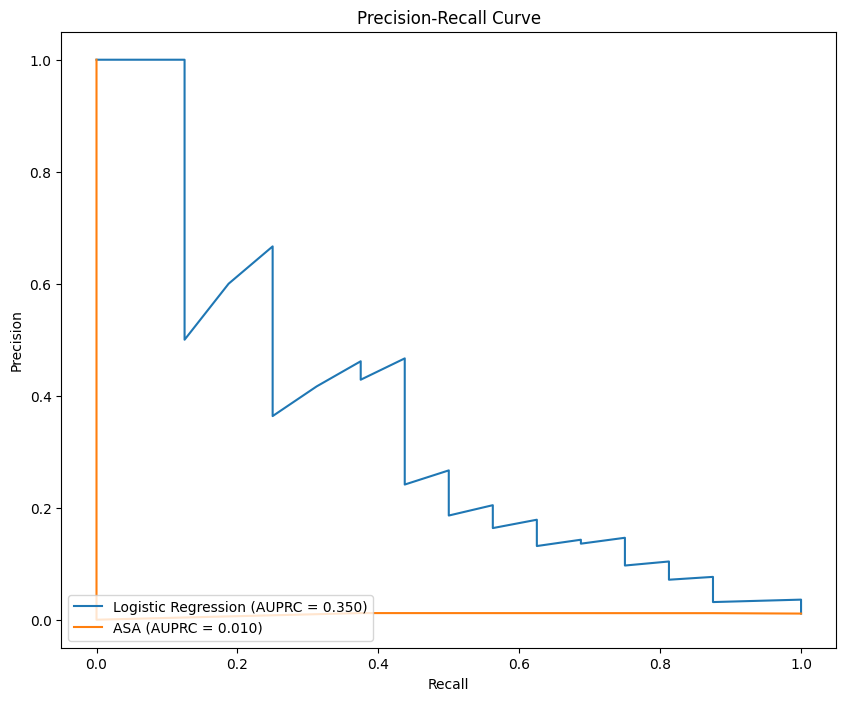

      Metric  Logistic Regression       ASA
0   Accuracy             0.990391       NaN
1  Precision             1.000000       NaN
2     Recall             0.125000       NaN
3   F1 Score             0.222222       NaN
4      AUROC             0.939018  0.524419
5      AUPRC             0.350043  0.009532
              op_id    subject_id       hadm_id       case_id        opdate  \
count  4.856000e+03  4.856000e+03  4.856000e+03    624.000000  4.856000e+03   
mean   4.460692e+08  1.502260e+08  2.501051e+08    383.491987  9.560461e+04   
std    2.912596e+07  2.867030e+07  2.861470e+07  21507.397540  4.560450e+05   
min    4.000170e+08  1.000103e+08  2.000048e+08 -32717.000000  0.000000e+00   
25%    4.202172e+08  1.255292e+08  2.253534e+08 -21855.000000  1.440000e+03   
50%    4.447431e+08  1.504818e+08  2.505266e+08   5402.500000  2.880000e+03   
75%    4.715495e+08  1.751646e+08  2.748569e+08  20265.750000  7.200000e+03   
max    4.999286e+08  1.999877e+08  2.999760e+08  32754.00000

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split

# Assuming df, INPUT_VARS, and OUTCOME_VAR are already defined

# Shuffle and split the dataset
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
ntrain = int(len(df) * 0.7)

# Stratified split
x_train, x_test, y_train, y_test = train_test_split(
    df[INPUT_VARS], df[OUTCOME_VAR], test_size=0.3, stratify=df[OUTCOME_VAR], random_state=1
)

# Print the number of train and test sets
print(f'{sum(y_train)}/{len(y_train)} ({np.mean(y_train)*100:.2f}%) train, {sum(y_test)}/{len(y_test)} ({np.mean(y_test)*100:.2f}%) test, {x_train.shape[1]} features', flush=True)

# ASA class
y_pred_asa = df.loc[ntrain:, 'asa']

# Compute area under the ROC AUC from prediction scores
auroc_asa = roc_auc_score(y_test, y_pred_asa)

# Compute the precision recall curve
prc_asa, rec_asa, thresholds = precision_recall_curve(y_test, y_pred_asa)

# Compute area under the precision-recall curve
auprc_asa = auc(rec_asa, prc_asa)
print('ASA auroc: {:.3f}, auprc: {:.3f}'.format(auroc_asa, auprc_asa), flush=True)

# Logistic regression using SimpleImputer()
imp = SimpleImputer().fit(x_train)
x_train_imputed = imp.transform(x_train)
x_test_imputed = imp.transform(x_test)

# Logistic regression using LogisticRegression()
model = LogisticRegression(max_iter=5000).fit(x_train_imputed, y_train)
y_pred_lr = model.predict_proba(x_test_imputed)[:, 1]

# Compute AUROC and AUPRC
auroc_lr = roc_auc_score(y_test, y_pred_lr)
prc_lr, rec_lr, thresholds = precision_recall_curve(y_test, y_pred_lr)
auprc_lr = auc(rec_lr, prc_lr)
print('LR auroc: {:.3f}, auprc: {:.3f}'.format(auroc_lr, auprc_lr), flush=True)
print(" \n ")

# Compute feature importance
feature_names = x_train.columns
coefficients = model.coef_[0]

# Create a list of (feature_name, absolute_coefficient) tuples and sort them by the coefficient value
features_coefficients = sorted(zip(feature_names, abs(coefficients)), key=lambda x: x[1], reverse=True)

# Unzip the feature names and their corresponding coefficients into separate lists
sorted_features, sorted_coefficients = zip(*features_coefficients)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_coefficients, color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # invert the y-axis to have the most important feature on top
plt.show()

# ROC Curve and AUC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
fpr_asa, tpr_asa, _ = roc_curve(y_test, y_pred_asa)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auroc_lr:.3f})')
plt.plot(fpr_asa, tpr_asa, label=f'ASA (AUC = {auroc_asa:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
y_pred_label_lr = (y_pred_lr >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_label_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print model performance metrics
accuracy = accuracy_score(y_test, y_pred_label_lr)
precision = precision_score(y_test, y_pred_label_lr)
recall = recall_score(y_test, y_pred_label_lr)
f1 = f1_score(y_test, y_pred_label_lr)
print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 Score: {f1:.3f}')

# Precision-Recall Curve
plt.figure(figsize=(10, 8))
plt.plot(rec_lr, prc_lr, label=f'Logistic Regression (AUPRC = {auprc_lr:.3f})')
plt.plot(rec_asa, prc_asa, label=f'ASA (AUPRC = {auprc_asa:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


# Tables

# Model Performance Metrics
metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUROC', 'AUPRC'],
    'Logistic Regression': [accuracy, precision, recall, f1, auroc_lr, auprc_lr],
    'ASA': [None, None, None, None, auroc_asa, auprc_asa]  # ASA metrics, except AUROC and AUPRC, are not computed
}
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Descriptive Statistics of the Dataset
desc_stats = df.describe()
print(desc_stats)

# Logistic Regression Coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)
print(coef_df)

# Confusion Matrix (numerical representation)
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print(cm_df)
